<a href="https://colab.research.google.com/github/fionnwhelan/Aorta_Segmentation/blob/main/CT_Segmentation_Greyscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Converting the Dicom Images to JPG (LIDC Datasets)](#scrollTo=IUc3UymI4K8L)

>[Converting the DICOM Files to JPEG (adjusted for USC Datasets)](#scrollTo=JP4aXcgPXcMr)

>[Loading and Saving ANALYZE Segmented Mask as PNG (Don't Run)](#scrollTo=mRk2RpcnKI7O)

>[Only Need to Run Code Below Here](#scrollTo=efCI9VXq_V79)

>[Image Preprocessing](#scrollTo=laT3SlI3hogB)

>[Defining the Model](#scrollTo=UkF3GzryrX7B)

>[Saving the model to Drive/Loading the Model in from Drive](#scrollTo=Wq7PMq7meK35)

>[Saving the History](#scrollTo=HUVKV88Urtw6)

>[Calculating MeanIoU](#scrollTo=50FsE8str35h)

>[Displaying Predictions on the Test Data](#scrollTo=nCkW8wefNaDI)

>[Testing on Unseen Data](#scrollTo=XH452vpjB3DY)

>[Calculating MeanIoU for Unseen Dataset](#scrollTo=2wgPJL6fzrTE)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image, ImageEnhance
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
import tensorflow as tf
import shutil
from tensorflow.keras.metrics import MeanIoU
import random

In [ ]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.48.127.122:8470']


#Converting the Dicom Images to JPG (LIDC Datasets)

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00


In [ ]:
# Not required, requirement already satisfied
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt

In [ ]:
import os
import numpy as np
# import nibabel as nib
import matplotlib.image
import shutil

In [ ]:
from google.colab import files

Currently working on : LIDC-0836

In [ ]:
# Current CT being loaded
cur_CT = 'LIDC-0836'
img_num = '4' 

In [ ]:
slices = []

In [ ]:
for i in range(1, 10):
  image_path = '/content/drive/MyDrive/Final_Year_Project/Final_Year_Project_Raw_Data/' + cur_CT + '/00000' + str(i) + '.dcm'
  ds = dicom.dcmread(image_path)
  slices.append(ds)

for i in range(10, 100):
  image_path = '/content/drive/MyDrive/Final_Year_Project/Final_Year_Project_Raw_Data/' + cur_CT + '/0000' + str(i) + '.dcm'
  ds = dicom.dcmread(image_path)
  slices.append(ds)

# Don't forget to update range (should be 1 greater than the highest dcm number)
for i in range(100, 172):
  image_path = '/content/drive/MyDrive/Final_Year_Project/Final_Year_Project_Raw_Data/' + cur_CT + '/000' + str(i) + '.dcm'
  ds = dicom.dcmread(image_path)
  slices.append(ds)

In [ ]:
slices = sorted(slices, key=lambda s: s.SliceLocation)

In [ ]:
type(slices)

list

In [ ]:
# For LIDC-0836 Dataset Ordering is Reversed, so need to flip slices
slices = slices[::-1]

In [ ]:
for i in range(0, 9):
  ds = slices[i]
  tmp = ds.pixel_array
  name = 'image0' + img_num + '-00' + str(i+1) + '.jpg' # slices is 0 indexed but the names are 1 indexed, so need to add 1 to the name
  matplotlib.image.imsave(name, tmp)

for i in range(9, 99):
  ds = slices[i]
  tmp = ds.pixel_array
  name = 'image0' + img_num + '-0' + str(i+1) + '.jpg'
  matplotlib.image.imsave(name, tmp)

# Don't forget to update the range (should be number of dcm images exactly)
for i in range(99, 171):
  ds = slices[i]
  tmp = ds.pixel_array
  name = 'image0' + img_num + '-' + str(i+1) + '.jpg'
  matplotlib.image.imsave(name, tmp)

Moving the files to Drive

In [ ]:
# Moving the files to Drive
for i in range(1, 10):
  old_path = '/content/image0' + img_num + '-00' + str(i) + '.jpg'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_CT + '/images/image0' + img_num + '-00' + str(i) + '.jpg'
  shutil.move(old_path, new_path)

for i in range(10, 100):
  old_path = '/content/image0' + img_num + '-0' + str(i) + '.jpg'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_CT + '/images/image0' + img_num + '-0' + str(i) + '.jpg'
  shutil.move(old_path, new_path)

# Don't forget to update range (should be 1 higher than number of .dcm files)
for i in range(100, 172): 
  old_path = '/content/image0' + img_num + '-' + str(i) + '.jpg'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_CT + '/images/image0' + img_num + '-' + str(i) + '.jpg'
  shutil.move(old_path, new_path)

#Converting the DICOM Files to JPEG (adjusted for USC Datasets)

In [ ]:
 # Current CT being loaded
cur_CT = 'USC-0173' # Needs to be a string
img_num = '14' 

In [ ]:
slices = []

# Don't forget to update range (should be 1 greater than the highest dcm number)
for i in range(1, 450):
  image_path = '/content/drive/MyDrive/Final_Year_Project/Final_Year_Project_Raw_Data/' + cur_CT + '/IM' + str(i) + '.dcm'
  ds = dicom.dcmread(image_path)
  slices.append(ds)

# Sorting the slices passed on SliceLocation Attribute
slices = sorted(slices, key=lambda s: s.SliceLocation)

In [ ]:
# Converting the DCM Files to Pixel Arrays, and Saving as JPEG
for i in range(0, 9):
  ds = slices[i]
  tmp = ds.pixel_array
  name = 'image' + img_num + '-00' + str(i+1) + '.jpg' # slices is 0 indexed but the names are 1 indexed, so need to add 1 to the name
  matplotlib.image.imsave(name, tmp)

for i in range(9, 99):
  ds = slices[i]
  tmp = ds.pixel_array
  name = 'image' + img_num + '-0' + str(i+1) + '.jpg'
  matplotlib.image.imsave(name, tmp)

# Don't forget to update the range (should be number of dcm images exactly)
for i in range(99, 449):
  ds = slices[i]
  tmp = ds.pixel_array
  name = 'image' + img_num + '-' + str(i+1) + '.jpg'
  matplotlib.image.imsave(name, tmp)

Moving the files to Drive

In [ ]:
# Moving the files to Drive
for i in range(1, 10):
  old_path = '/content/image' + img_num + '-00' + str(i) + '.jpg'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_CT + '/images/image' + img_num + '-00' + str(i) + '.jpg'
  shutil.move(old_path, new_path)

for i in range(10, 100):
  old_path = '/content/image' + img_num + '-0' + str(i) + '.jpg'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_CT + '/images/image' + img_num + '-0' + str(i) + '.jpg'
  shutil.move(old_path, new_path)

# Don't forget to update range (should be 1 higher than number of .dcm files)
for i in range(100, 450): 
  old_path = '/content/image' + img_num + '-' + str(i) + '.jpg'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_CT + '/images/image' + img_num + '-' + str(i) + '.jpg'
  shutil.move(old_path, new_path)

# Loading and Saving ANALYZE Segmented Mask as PNG (Don't Run)

Both .hdr and .img files need to be uploaded in order for nibabel to open the file. This is the analyze format, where some information is stored in .hdr and some is stored in .img

In [ ]:
from nibabel.testing import data_path
example_filename = '/content/drive/MyDrive/Final_Year_Project/Final_Year_Project_Raw_Data/LIDC-0836/manual_segmentation_from_radiologist.hdr'

In [ ]:
analyze = nib.load(example_filename).get_fdata()
analyze.shape

(512, 512, 171, 1)

In [ ]:
test1 = analyze[:,:,200]
test2 = np.squeeze(test1)
plt.imshow(test2)
plt.show()

In [ ]:
for i in range(1, 10):
  tmp = analyze[:,:,i]
  tmp = np.squeeze(tmp)
  matplotlib.image.imsave('image0400' + str(i) + '.png', tmp)

In [ ]:
for i in range(10, 100):
  tmp = analyze[:,:,i]
  tmp = np.squeeze(tmp)
  matplotlib.image.imsave('image040' + str(i) + '.png', tmp)

In [ ]:
# Don't forget to update range

for i in range(100, 171):
  tmp = analyze[:,:,i]
  tmp = np.squeeze(tmp)
  matplotlib.image.imsave('image04' + str(i) + '.png', tmp)

In [ ]:
for i in range(1, 10):
  old_path = '/content/image0400' + str(i) + '.png'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/annotations/image0400' + str(i) + '.png'
  shutil.move(old_path, new_path)

In [ ]:
for i in range(10, 100):
  old_path = '/content/image040' + str(i) + '.png'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/annotations/image040' + str(i) + '.png'
  shutil.move(old_path, new_path)

In [ ]:
# Don't forget to update range

for i in range(100, 171):
  old_path = '/content/image04' + str(i) + '.png'
  new_path = '/content/drive/MyDrive/Final_Year_Project/Converted_Files/annotations/image04' + str(i) + '.png'
  shutil.move(old_path, new_path)

#Only Need to Run Code Below Here


# Image Preprocessing

In [ ]:
CTs_for_testing = ['LIDC-0001', 'LIDC-0029', 'LIDC-0126', 'LIDC-0836', 'USC-0053', 'USC-0055', 'USC-0100', 'USC-0119', 'USC-0139', 'USC-0141']

In [ ]:
# Loading the images
image_names = []
for cur_load_CT in CTs_for_testing:
  cur_names = glob.glob('/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_load_CT + '/images/*.jpg')
  cur_names.sort()
  image_names += cur_names

images = []

# For testing only
# image_names = image_names[:100]
# Randomly adjusts contrast. Need to apply contrast adjustment before resizing, otherwise it won't work
for img in image_names:
  image = cv2.imread(img, 0)
  image = tf.expand_dims(image, 2)
  image = tf.image.random_contrast(image, 0.05, 3)
  image = tf.image.resize(image, (128, 128))
  images.append(image)
image_dataset = np.array(images)
len(image_dataset)

133

In [ ]:
# Loading the masks
mask_names = []
for cur_load_CT in CTs_for_testing:
  cur_names = glob.glob('/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + cur_load_CT + '/annotations/*.png')
  cur_names.sort()
  mask_names += cur_names
masks = []

# For testing only
# mask_names = mask_names[:100]
# Don't need to adjust contrast of the masks
for mask in mask_names:
  mask = cv2.imread(mask, 0)
  mask = tf.expand_dims(mask, 2)
  mask = tf.image.resize(mask, (128, 128))
  masks.append(mask)
mask_dataset = np.array(masks)
len(mask_dataset)

133

In [ ]:
# Randomly zooming in or out of the images and masks
seed = random.randint(1, 1000)
print(seed)
layer = tf.keras.layers.RandomZoom(.2, fill_mode = 'nearest', seed=seed)
images_zoom = layer(image_dataset)
layer = tf.keras.layers.RandomZoom(.2, fill_mode = 'nearest', seed=seed)
masks_zoom = layer(mask_dataset)
images_zoom = np.array(images_zoom)
masks_zoom = np.array(masks_zoom)

824


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (133, 128, 128, 1)
Mask data shape is:  (133, 128, 128, 1)
Max pixel value in image is:  255.0
Labels in the mask are :  [ 30.    76.25 122.5  168.75 215.  ]


In [ ]:
images_zoom = images_zoom/255.
masks_zoom = masks_zoom/255.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_zoom, masks_zoom, test_size = 0.20, shuffle=True)

In [ ]:
len(X_train)

106

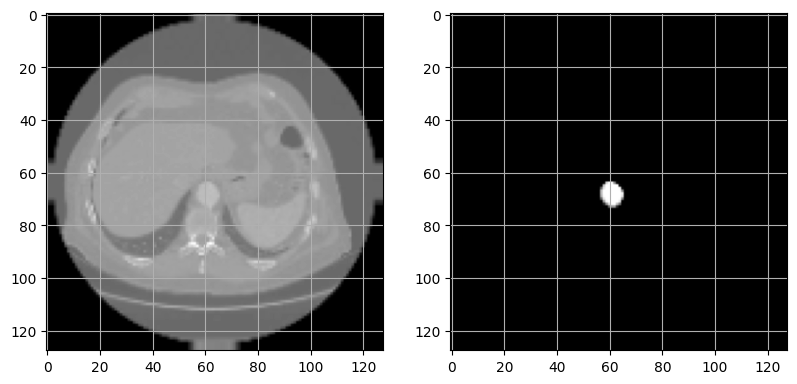

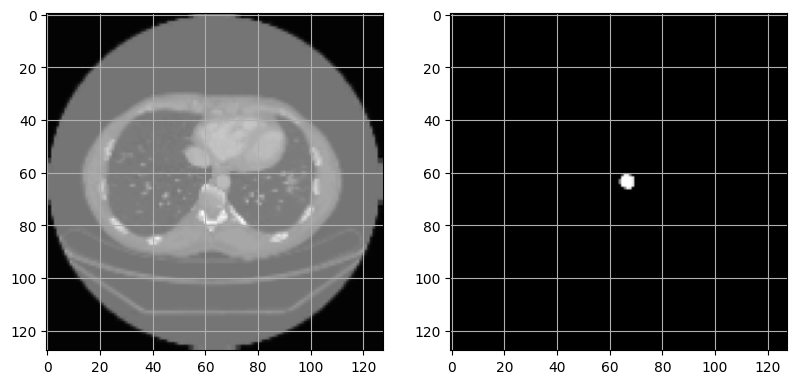

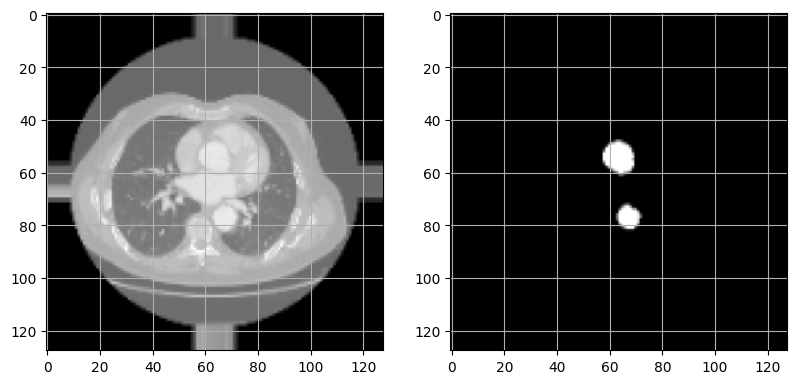

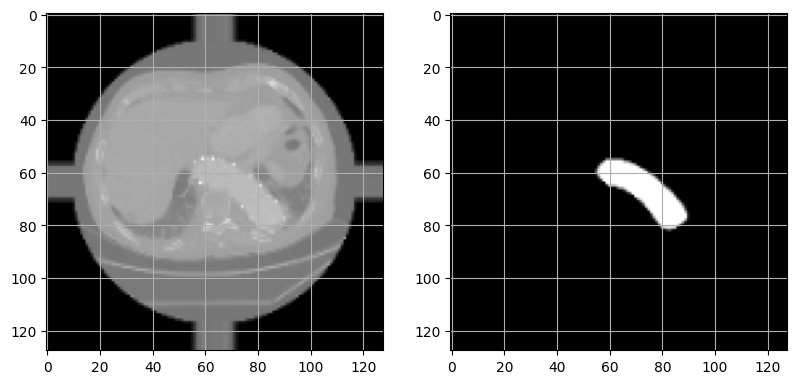

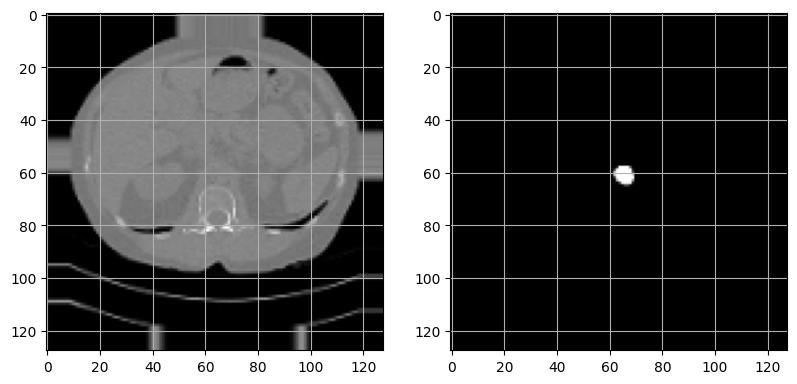

In [ ]:
for i in range(5):
  image_number = random.randint(0, len(X_train)-1)
  plt.figure(figsize=(20,10))
  plt.subplot(141)
  plt.imshow(X_train[image_number,:,:,0], cmap='gray')
  plt.grid()
  plt.subplot(142)
  plt.imshow(y_train[image_number,:,:,0], cmap='gray')
  plt.grid()
  plt.show


#Defining the Model

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model
  

In [ ]:
# Model with extra encoder and decoder added
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)

    b1 = conv_block(p5, 2048) #Bridge

    d0 = decoder_block(b1, s5, 1024)
    d1 = decoder_block(d0, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


In [ ]:
# This builds the model normally. The model will not be trained on the TPU.
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                     

In [ ]:
tpu_strategy.num_replicas_in_sync

8

In [ ]:
# This builds the model in the TPU. The model will train on the TPU.
with tpu_strategy.scope():
  model = build_unet(input_shape, n_classes=1)
  model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanAbsoluteError()])
  model.summary()

In [ ]:
# Training on TPU worked when batch size was changed from 16 to 60 (generally the batch size can't be too low compared to the size of the training data)
batch_size = 12*tpu_strategy.num_replicas_in_sync
steps_per_epoch = len(X_train)//batch_size
validation_steps = len(X_test)//batch_size

In [ ]:
# Need to load most recent model before training!!!
history = model.fit(X_train, y_train, 
                    batch_size = batch_size, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps)

Epoch 1/100
23/23 [==============================] - 67s 849ms/step - loss: 0.4588 - mean_absolute_error: 0.1320 - val_loss: 2498.7952 - val_mean_absolute_error: 0.8111
Epoch 2/100
23/23 [==============================] - 30s 317ms/step - loss: 0.3740 - mean_absolute_error: 0.0177 - val_loss: 759.4237 - val_mean_absolute_error: 0.7560
Epoch 3/100
23/23 [==============================] - 7s 315ms/step - loss: 0.3734 - mean_absolute_error: 0.0156 - val_loss: 4.7838 - val_mean_absolute_error: 0.3618
Epoch 4/100
23/23 [==============================] - 7s 315ms/step - loss: 0.3733 - mean_absolute_error: 0.0151 - val_loss: 0.4301 - val_mean_absolute_error: 0.1437
Epoch 5/100
23/23 [==============================] - 7s 313ms/step - loss: 0.3728 - mean_absolute_error: 0.0152 - val_loss: 0.4678 - val_mean_absolute_error: 0.1892
Epoch 6/100
23/23 [==============================] - 7s 315ms/step - loss: 0.3718 - mean_absolute_error: 0.0150 - val_loss: 0.4387 - val_mean_absolute_error: 0.1503
Epo

#Saving the model to Drive/Loading the Model in from Drive

In [ ]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save('./LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep', options=save_locally)


In [ ]:
# Moving Model to Drive
source = '/content/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep'
destination = '/content/drive/MyDrive/Final_Year_Project/Models/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep'

In [ ]:
shutil.copytree(source, destination)

'/content/drive/MyDrive/Final_Year_Project/Models/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep'

In [ ]:
# Loading Model from Drive
source = '/content/drive/MyDrive/Final_Year_Project/Models/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep'
destination = '/content/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep'

In [ ]:
shutil.copytree(source, destination)

'/content/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep'

In [ ]:
with tpu_strategy.scope():
  load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
  model = tf.keras.models.load_model('./LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep', options=load_locally)

#Saving the History

In [ ]:
import json

In [ ]:
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('./LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep_hist', 'w'))

In [ ]:
# Moving History from Colab to Drive
source = '/content/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep_hist'
destination = '/content/drive/MyDrive/Final_Year_Project/Models/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep_hist'
shutil.copyfile(source, destination)

'/content/drive/MyDrive/Final_Year_Project/Models/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep_hist'

In [ ]:
# Moving History from Drive to Colab
source = '/content/drive/MyDrive/Final_Year_Project/Models/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_hist'
destination = '/content/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_hist'
shutil.copyfile(source, destination)

'/content/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_hist'

In [ ]:
history = json.load(open('/content/LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_hist', 'r'))

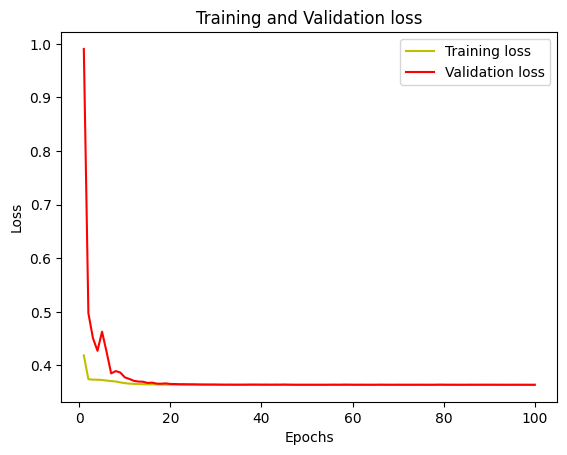

ValueError: ignored

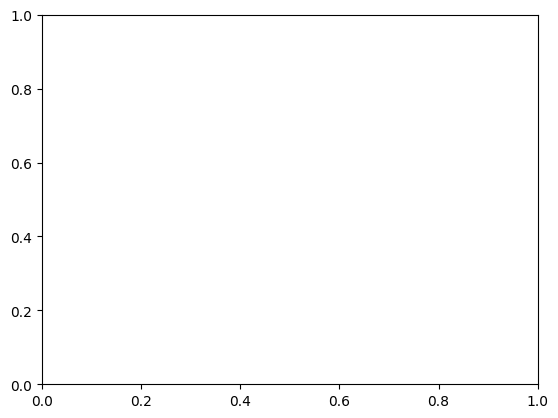

In [ ]:
# loss = history.history['loss']
loss = history['loss'] # [20:60]
# val_loss = history.history['val_loss']
val_loss = history['val_loss'] # [20:60]
epochs = range(1, len(loss) + 1)
# epochs = range(20, 60)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 # plt.yscale('log')
plt.legend()
plt.show()

# mee = history.history['mean_absolute_error']
mee = history['mean_absolute_error'][20:60]
# val_mee = history.history['val_mean_absolute_error']
val_mee = history['val_mean_absolute_error'][20:60]
plt.plot(epochs, mee, 'y', label='Training MAE')
plt.plot(epochs, val_mee, 'r', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

#Calculating MeanIoU

In [ ]:
# Calculating MeanIoU for the Dataset the Model was trained on
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.4960996


#Displaying Predictions on the Test Data 

In [ ]:
type(X_test[1])

numpy.ndarray

In [ ]:
import random

(1, 128, 128, 1)
1/1 [==============================] - 10s 10s/step
(128, 128)


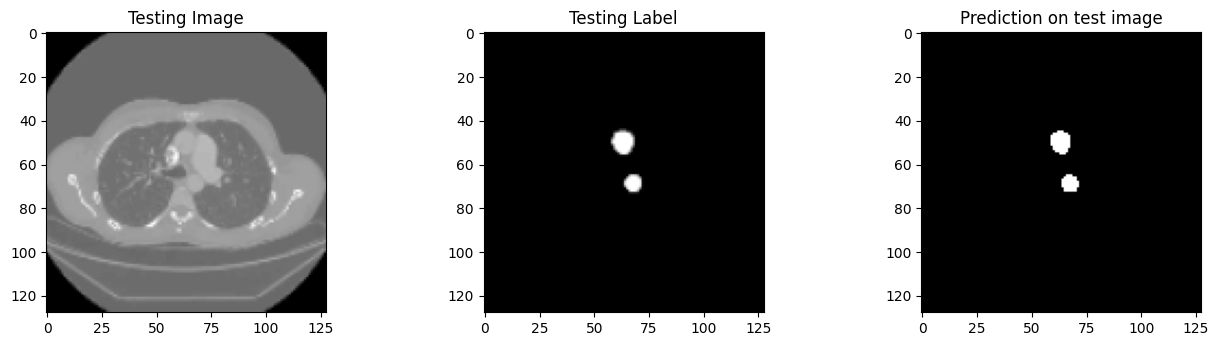

(1, 128, 128, 1)
1/1 [==============================] - 1s 651ms/step
(128, 128)


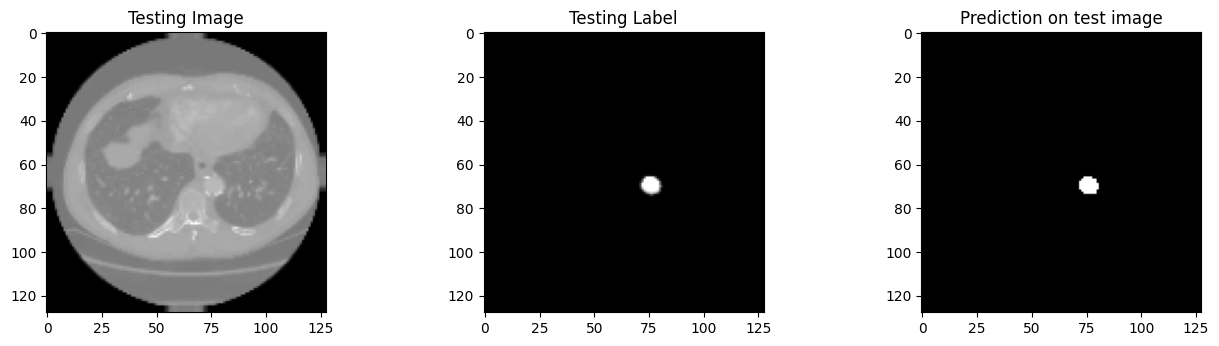

(1, 128, 128, 1)
1/1 [==============================] - 1s 589ms/step
(128, 128)


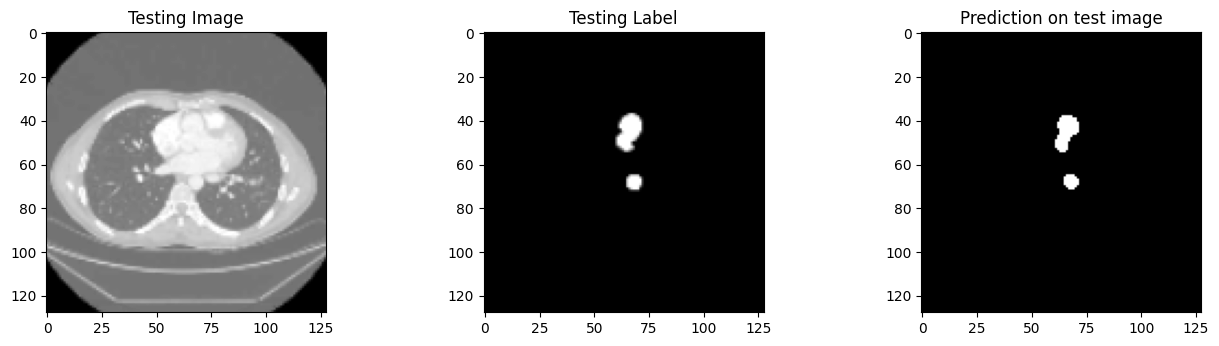

(1, 128, 128, 1)
1/1 [==============================] - 1s 644ms/step
(128, 128)


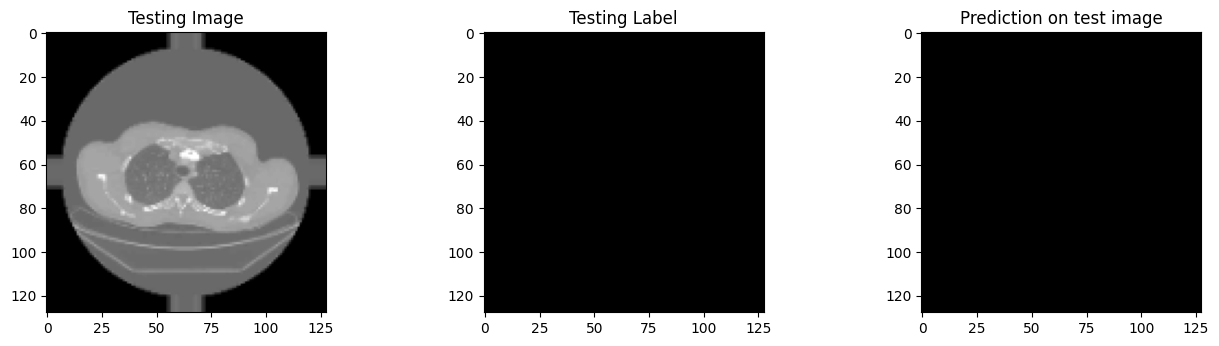

(1, 128, 128, 1)
1/1 [==============================] - 1s 645ms/step
(128, 128)


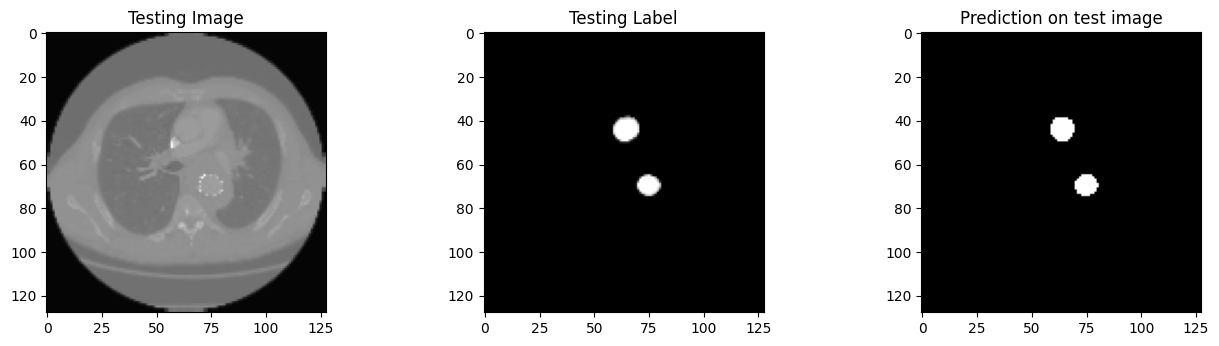

(1, 128, 128, 1)
1/1 [==============================] - 1s 776ms/step
(128, 128)


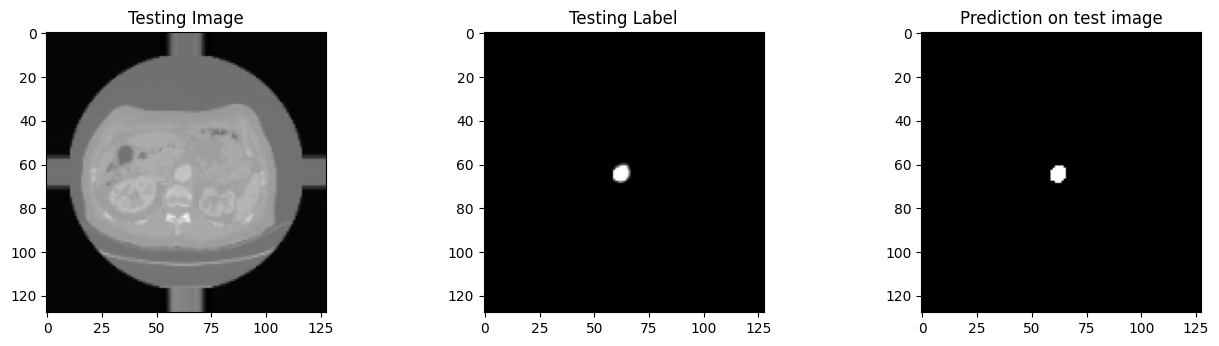

(1, 128, 128, 1)
1/1 [==============================] - 1s 711ms/step
(128, 128)


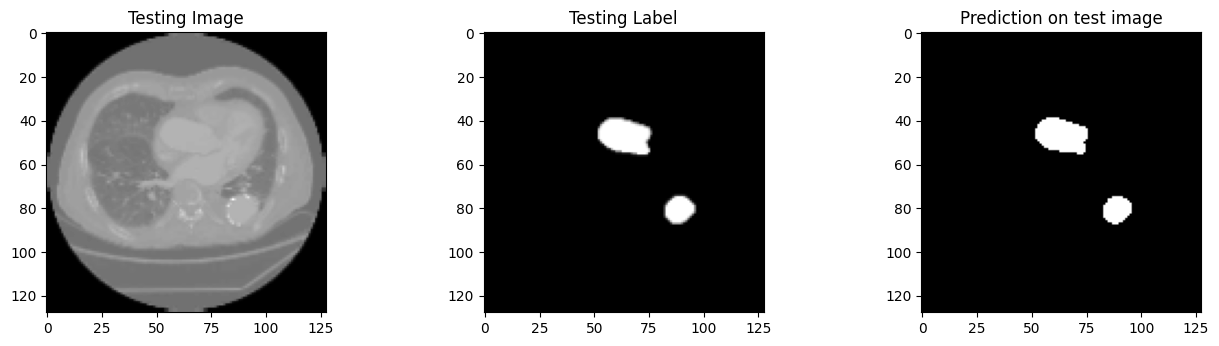

(1, 128, 128, 1)
1/1 [==============================] - 1s 744ms/step
(128, 128)


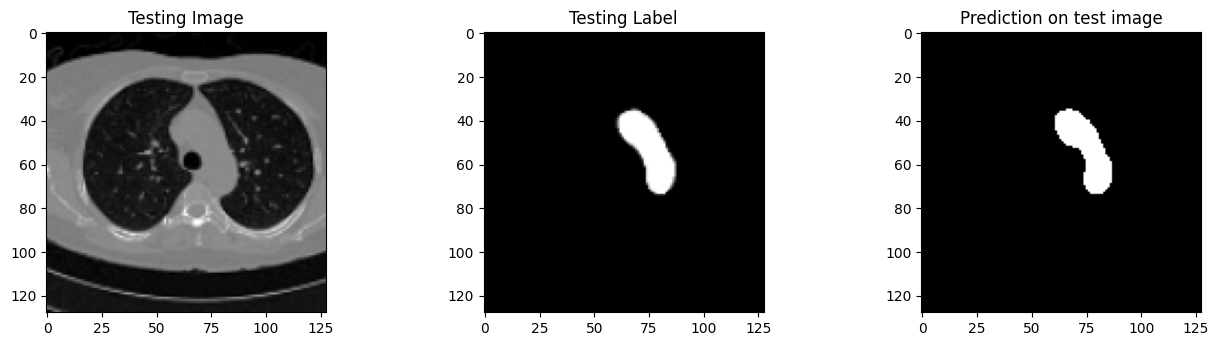

(1, 128, 128, 1)
1/1 [==============================] - 1s 598ms/step
(128, 128)


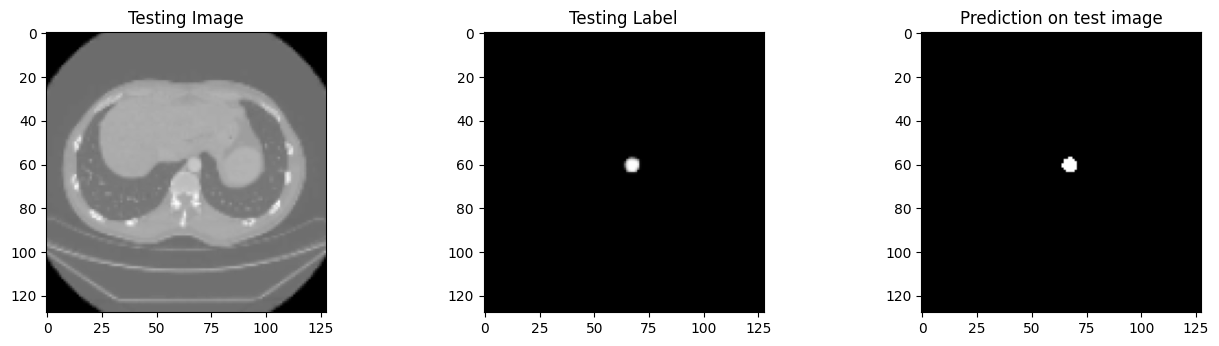

(1, 128, 128, 1)
1/1 [==============================] - 1s 599ms/step
(128, 128)


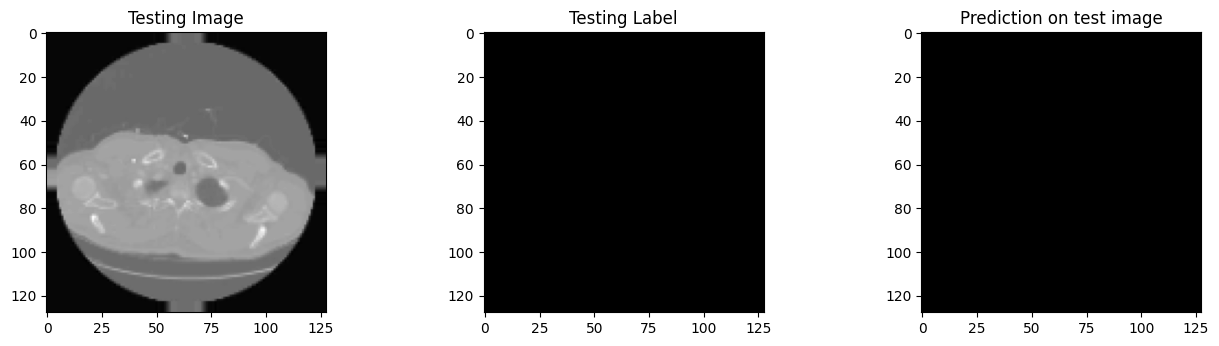

In [ ]:
threshold = 0.5
for i in range(0, 10):
  test_img_number =  random.randint(0, len(X_test)-1)
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  print(test_img_input.shape)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
  print(prediction.shape)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(prediction, cmap='gray')

  plt.show()
    

Storing the predictions as a series of arrays

#Testing on Unseen Data

In [ ]:
LIDC_126_836_USC_100_119_139_149_164_173_75ep

In [ ]:
unseen_dataset = 'USC-0149'

In [ ]:
image_names_test = glob.glob('/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + unseen_dataset + '/images/*.jpg')
image_names_test.sort()
images_test = []
for img in image_names_test:
  image = cv2.imread(img, 0)
  image = tf.expand_dims(image, 2)
  image = tf.image.resize(image, (128, 128))
  images_test.append(image)
image_dataset_test = np.array(images_test)
print(image_dataset_test.shape)

(429, 128, 128, 1)


In [ ]:
mask_names_test = glob.glob('/content/drive/MyDrive/Final_Year_Project/Converted_Files/' + unseen_dataset + '/annotations/*.png')
mask_names_test.sort()
masks_test = []
for img in mask_names_test:
  image = cv2.imread(img, 0)
  image = tf.expand_dims(image, 2)
  image = tf.image.resize(image, (128, 128))
  masks_test.append(image)
mask_dataset_test = np.array(masks_test)
print(image_dataset_test.shape)

(133, 128, 128, 1)


In [ ]:
image_dataset_test = image_dataset_test/255.
mask_dataset_test = mask_dataset_test/255.

In [ ]:
mask_dataset_test_thresholded = mask_dataset_test > 0.5

#Calculating MeanIoU for Unseen Dataset

In [ ]:
# Calculating MeanIoU for the Dataset the Model was trained on
y_pred=model.predict(image_dataset_test)
y_pred_thresholded = y_pred > 0.5

5/5 [==============================] - 1s 80ms/step


In [ ]:
# New method with accurate IoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, mask_dataset_test_thresholded)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9462993


In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, mask_dataset_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.49768734


(1, 128, 128, 1)
1/1 [==============================] - 1s 514ms/step
(128, 128)


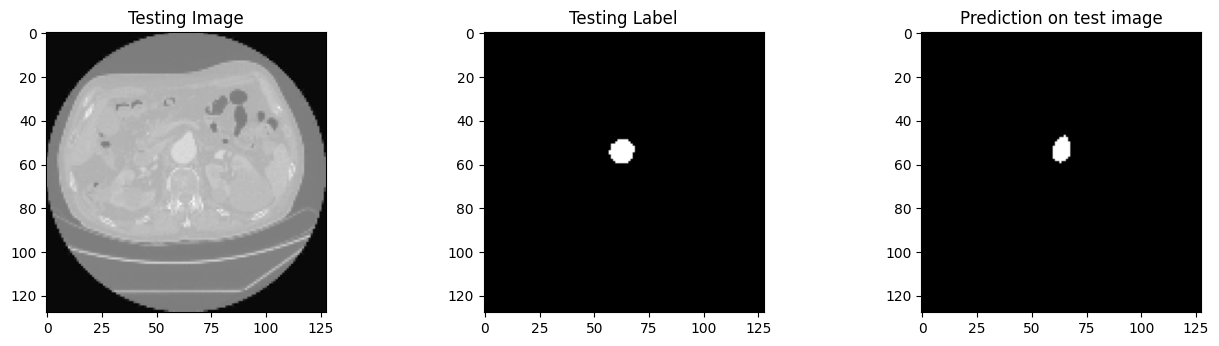

(1, 128, 128, 1)
1/1 [==============================] - 1s 575ms/step
(128, 128)


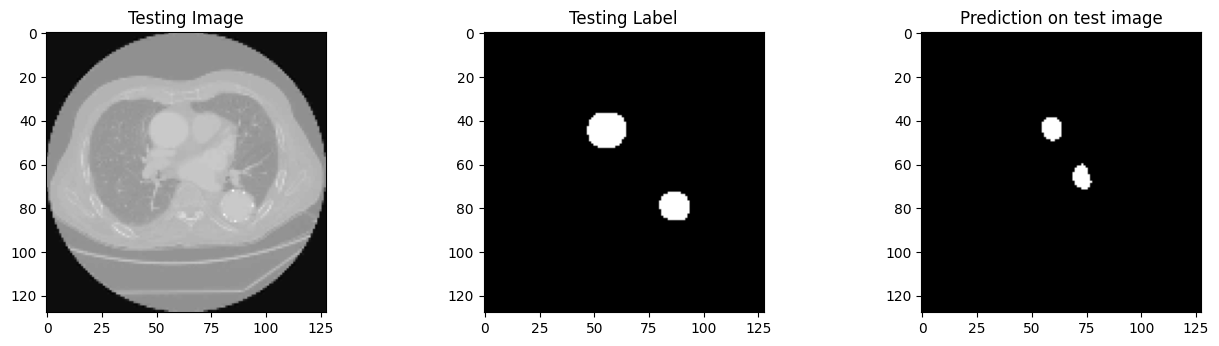

(1, 128, 128, 1)
1/1 [==============================] - 1s 509ms/step
(128, 128)


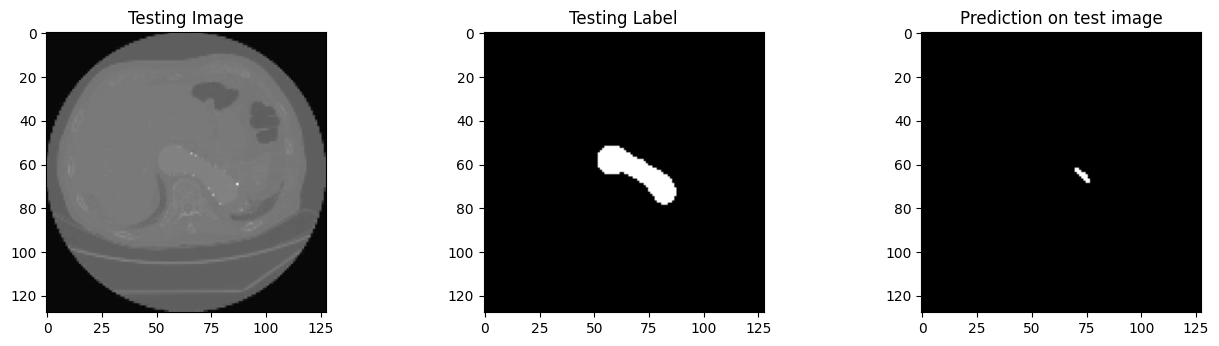

(1, 128, 128, 1)
1/1 [==============================] - 1s 558ms/step
(128, 128)


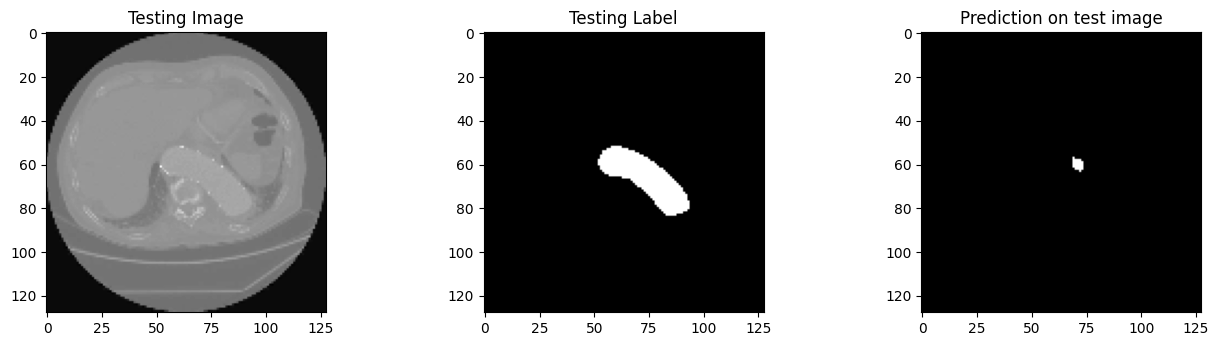

(1, 128, 128, 1)
1/1 [==============================] - 1s 528ms/step
(128, 128)


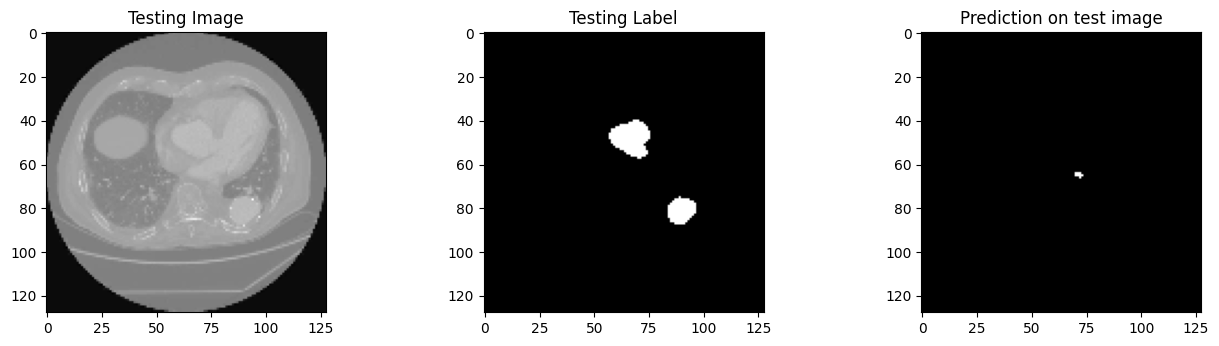

(1, 128, 128, 1)
1/1 [==============================] - 1s 521ms/step
(128, 128)


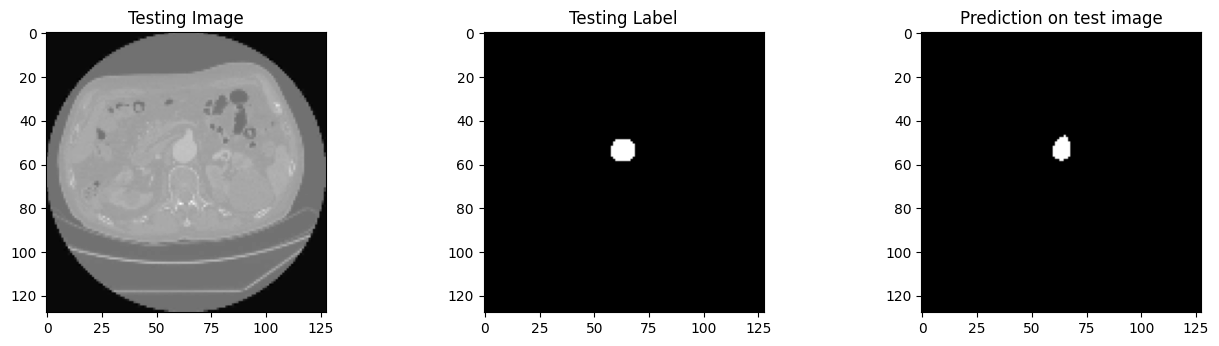

(1, 128, 128, 1)
1/1 [==============================] - 1s 519ms/step
(128, 128)


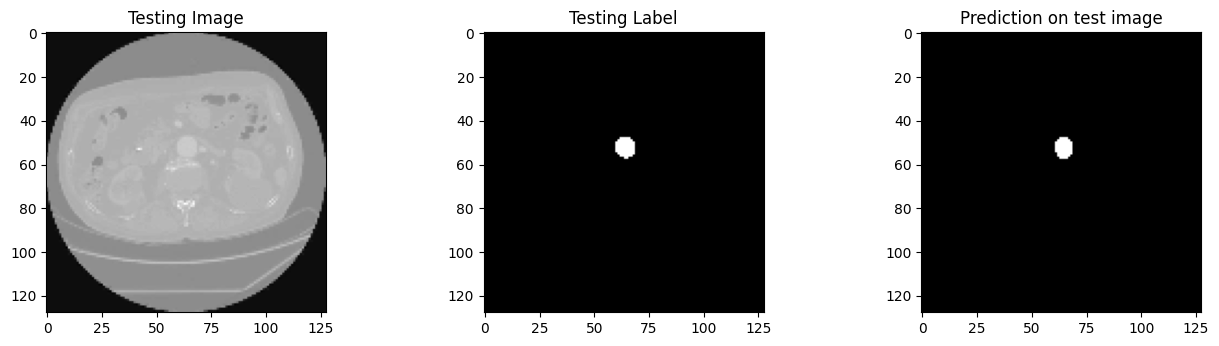

(1, 128, 128, 1)
1/1 [==============================] - 1s 508ms/step
(128, 128)


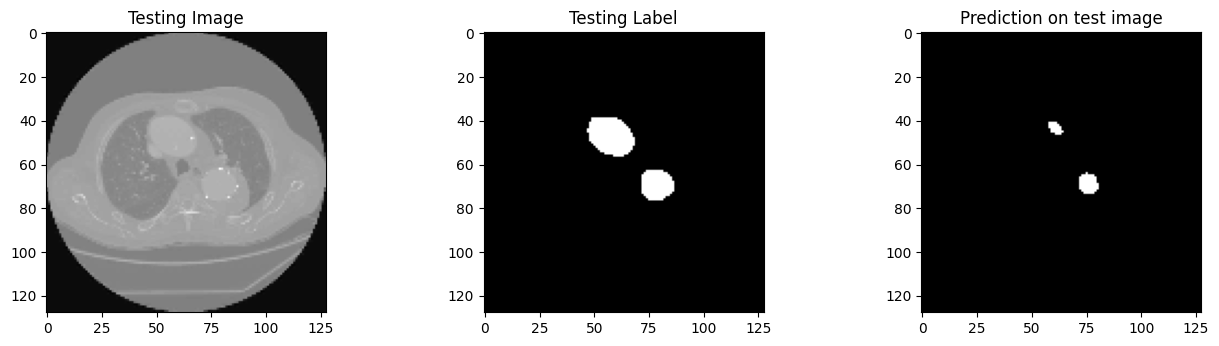

(1, 128, 128, 1)
1/1 [==============================] - 1s 504ms/step
(128, 128)


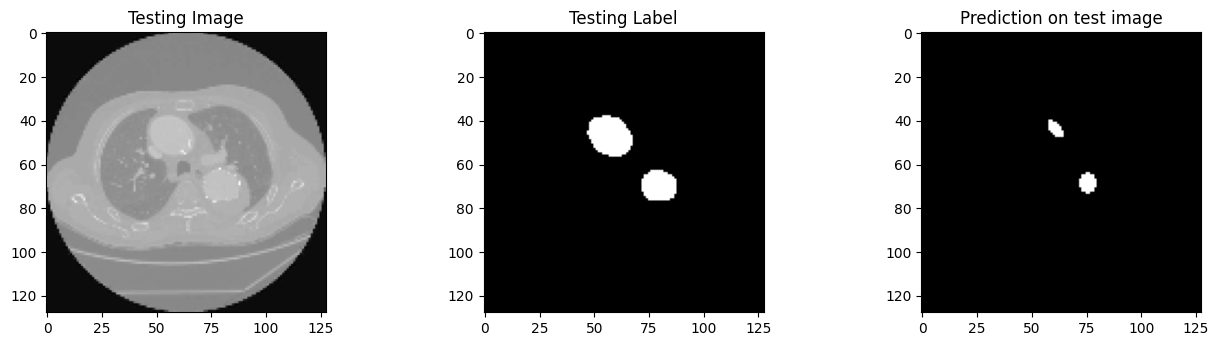

(1, 128, 128, 1)
1/1 [==============================] - 1s 517ms/step
(128, 128)


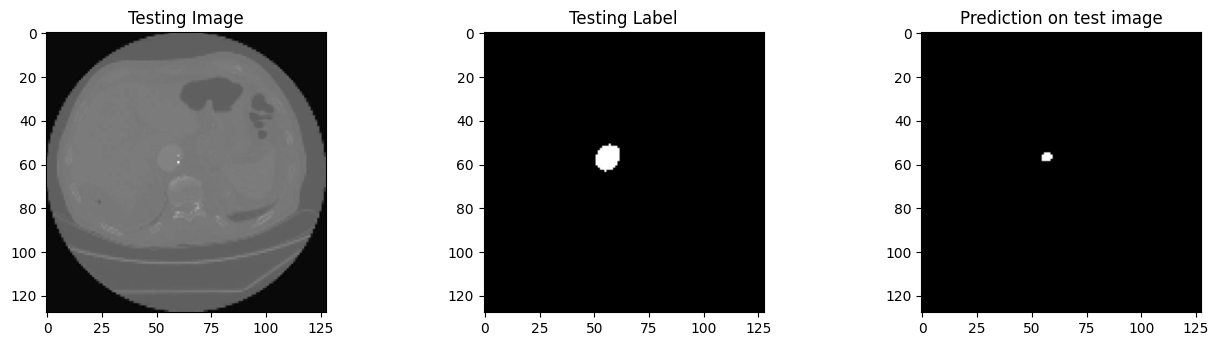

(1, 128, 128, 1)
1/1 [==============================] - 1s 512ms/step
(128, 128)


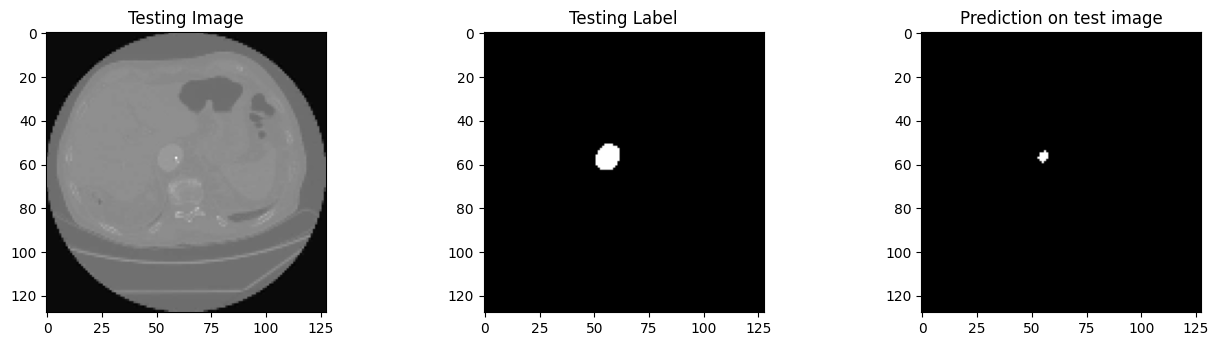

(1, 128, 128, 1)
1/1 [==============================] - 1s 523ms/step
(128, 128)


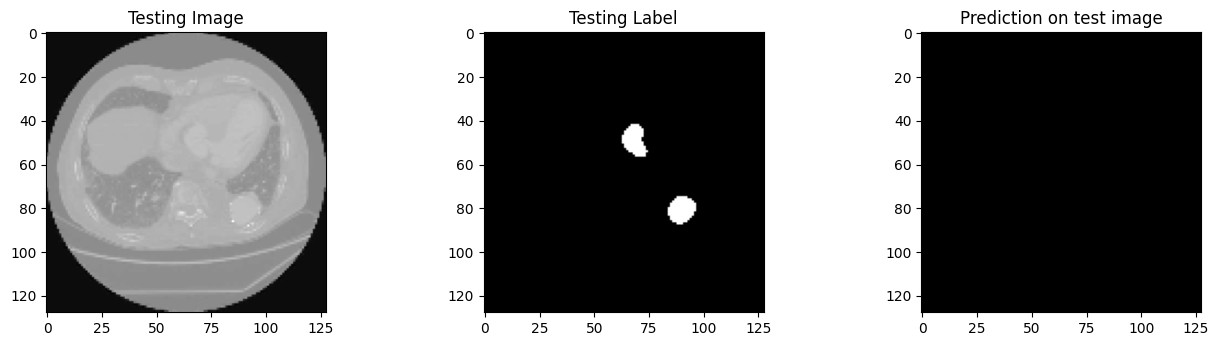

(1, 128, 128, 1)
1/1 [==============================] - 1s 984ms/step
(128, 128)


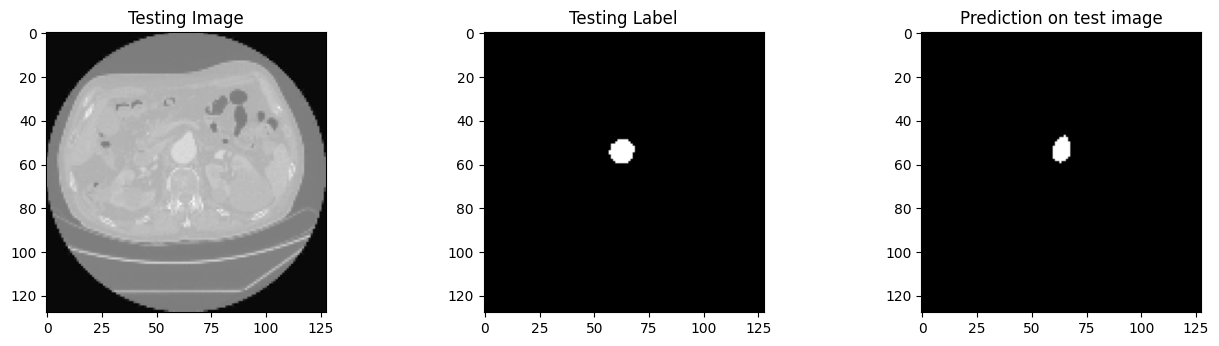

(1, 128, 128, 1)
1/1 [==============================] - 1s 550ms/step
(128, 128)


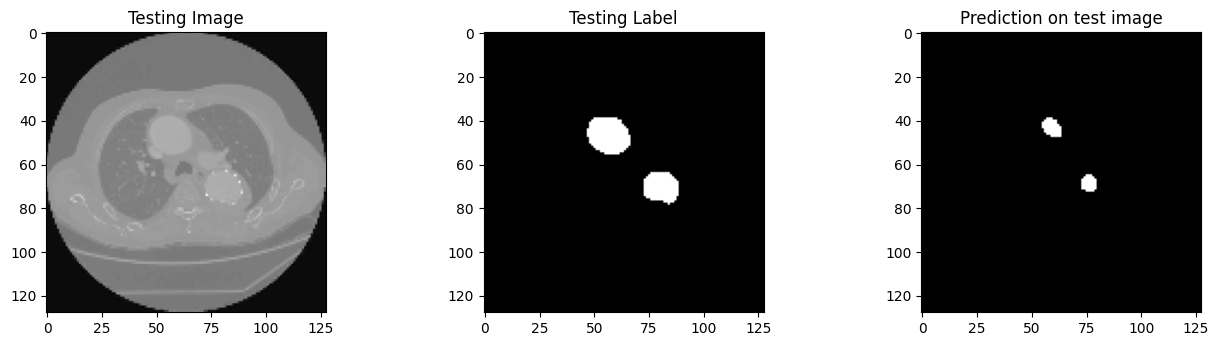

(1, 128, 128, 1)
1/1 [==============================] - 1s 511ms/step
(128, 128)


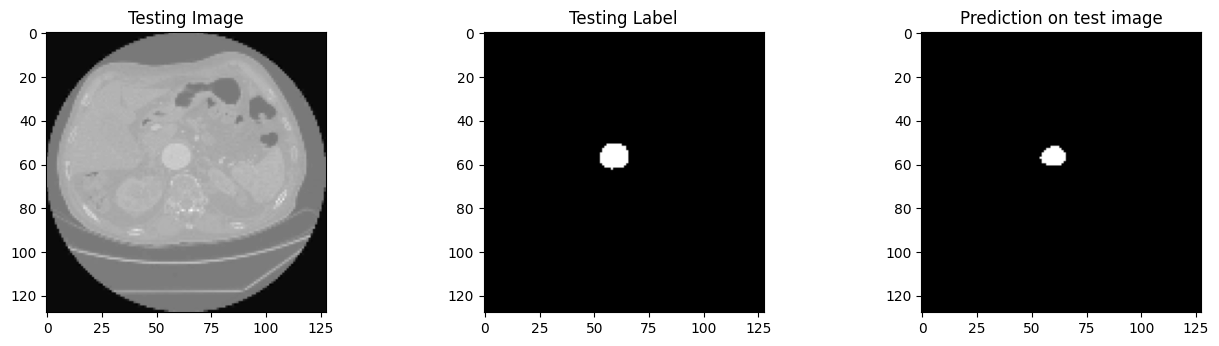

(1, 128, 128, 1)
1/1 [==============================] - 1s 547ms/step
(128, 128)


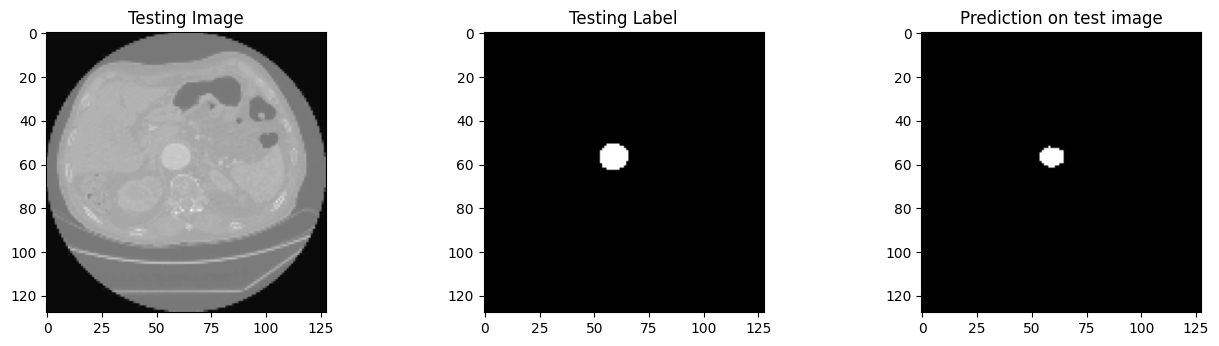

(1, 128, 128, 1)
1/1 [==============================] - 1s 536ms/step
(128, 128)


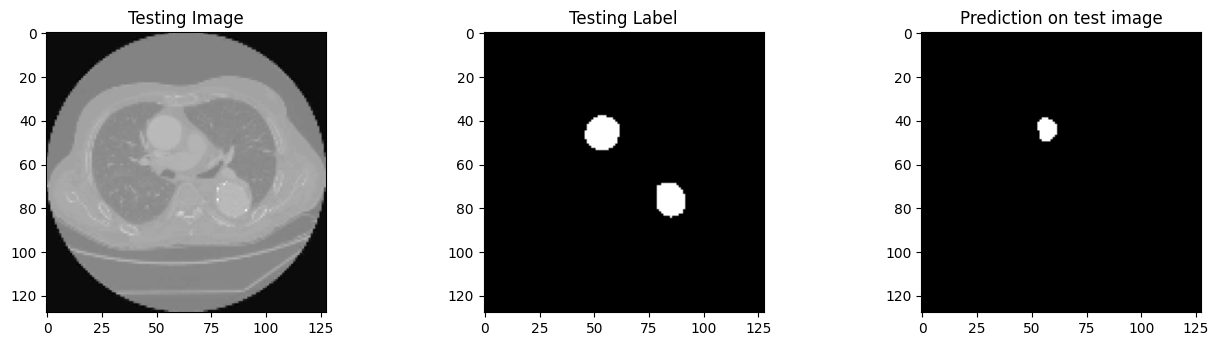

(1, 128, 128, 1)
1/1 [==============================] - 1s 520ms/step
(128, 128)


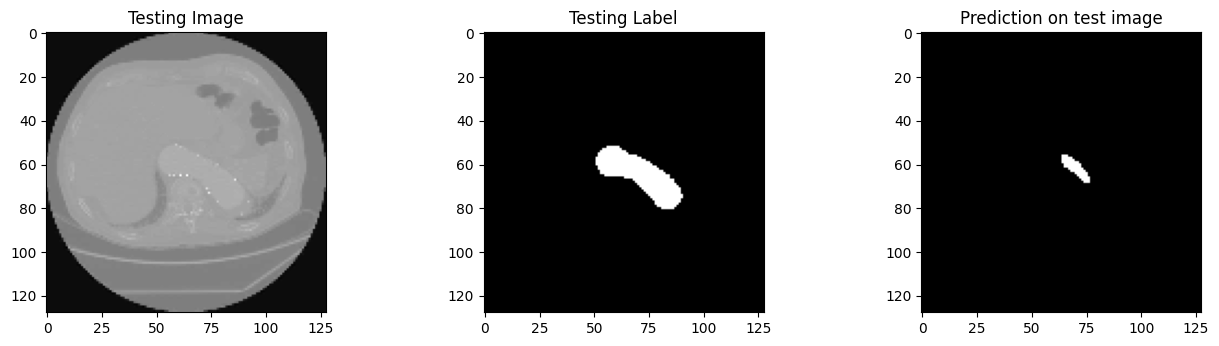

(1, 128, 128, 1)
1/1 [==============================] - 1s 520ms/step
(128, 128)


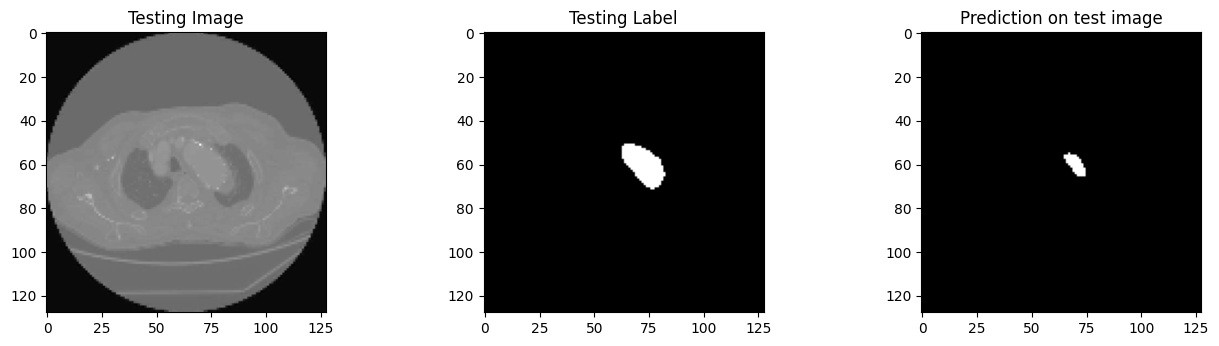

(1, 128, 128, 1)
1/1 [==============================] - 1s 542ms/step
(128, 128)


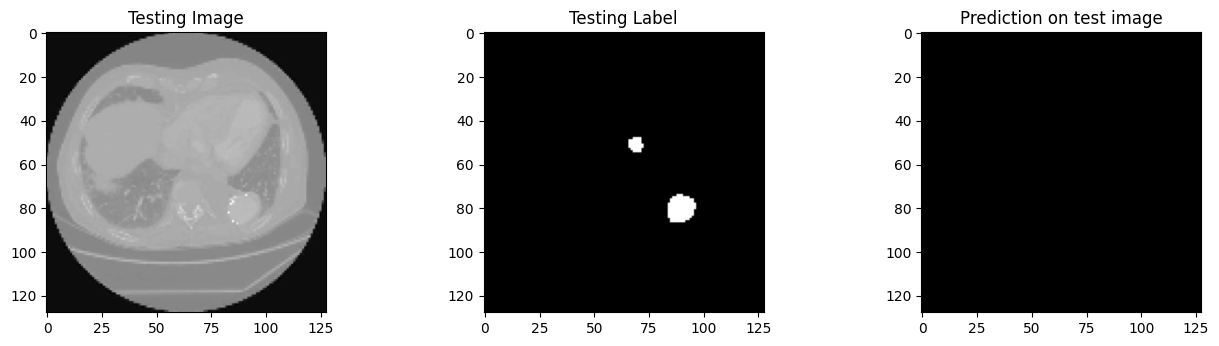

In [ ]:
threshold = 0.5
for i in range(20):
  test_img_number =  random.randint(0, len(image_dataset_test)-1)
  test_img = image_dataset_test[test_img_number]
  ground_truth = mask_dataset_test_thresholded[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  print(test_img_input.shape)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
  print(prediction.shape)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(prediction, cmap='gray')

  plt.show()

In [ ]:
# Storing the Predictions for the Entire CT in a List 
threshold = 0.5
predictions = []
for i in range(image_dataset_test.shape[0]):
      test_img_number = i
      test_img = image_dataset_test[test_img_number]
      test_img_input = np.expand_dims(test_img, 0)
      prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
      predictions.append(prediction)

1/1 [==============================] - 1s 531ms/step


In [ ]:
len(predictions)

449

In [ ]:
array_3d = np.dstack(predictions)

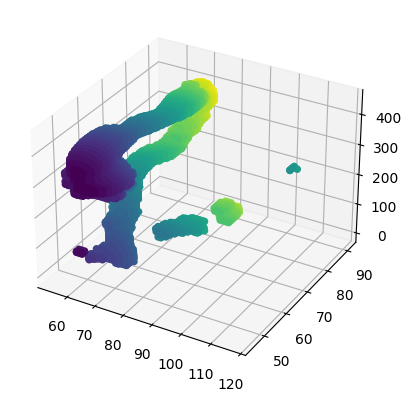

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = array_3d.nonzero()
ax.scatter(x, z, y, c=z, alpha=1)
plt.show()

In [ ]:
pip install numpy-stl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from stl import mesh
from skimage import measure

In [ ]:
# Need to adjust spacing here
verts, faces, normals, values = measure.marching_cubes(array_3d, 0, spacing=(1, 1, 1/4.0)) 

obj_3d = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))

for i, f in enumerate(faces):
    obj_3d.vectors[i] = verts[f]

In [ ]:
obj_3d.save('(USC-0173)_LIDC_1_29_126_836_USC_53_55_100_119_139_141_100ep_6deep.stl')

In [ ]:
source = '/content/(LIDC-0126)_LIDC_1_29_USC_53_55_100ep.stl'
destination = '/content/drive/MyDrive/Final_Year_Project/STL_Files/(LIDC-0126)_LIDC_1_29_USC_53_55_100ep.stl'

In [ ]:
shutil.move(source, destination)

'/content/drive/MyDrive/Final_Year_Project/STL_Files/(LIDC-0126)_LIDC_1_29_USC_53_55_100ep.stl.stl'